In [1]:
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt
import pinocchio as pin
from pinocchio.utils import rotate
from robot_descriptions.loaders.pinocchio import load_robot_description
from utils.meshcat_viewer_wrapper import MeshcatVisualizer
import pink
from pink import solve_ik
from pink.tasks import FrameTask
import qpsolvers
import time
from tqdm import tqdm

from scripts.humanoid_mpc import MPCRobust, feet, foot, MPCForce


## Import robot

In [2]:
robot = load_robot_description(
        "jvrc_description", root_joint=pin.JointModelFreeFlyer()
    )
configuration = pink.Configuration(robot.model, robot.data, robot.q0)
viz = MeshcatVisualizer(robot)
q0 = configuration.q.copy()
viz.display(q0)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


## MPC Control

In [3]:
viz.display(q0)

In [4]:
   
def get_parameters_robot(configuration):
    l_ankle_position = configuration.get_transform_frame_to_world("l_ankle").copy().translation
    r_ankle_position = configuration.get_transform_frame_to_world("r_ankle").copy().translation
    pelvis_position = configuration.get_transform_frame_to_world("root_joint").copy().translation
    
    leg_length = (pelvis_position - l_ankle_position)[-1]
    x_left_foot = l_ankle_position[1]
    x_right_foot = r_ankle_position[1]
    return leg_length, x_left_foot, x_right_foot    
    

In [5]:
leg_length, x_left_foot, x_right_foot = get_parameters_robot(configuration)
print(f'{leg_length}, {x_left_foot}, {x_right_foot}')

0.7460000000000002, 0.09600000000000043, -0.09600000000000025


<span style="color:red"> I coudn't make it work with the robot parameters h_COM!</span>.

In [6]:
leg_length, x_left_foot, x_right_foot = get_parameters_robot(configuration)
#x_left_foot = 0.05
x_right_foot = -x_left_foot
T = 5 * 1e-3
g = 9.87
h_CoM = 0.1
foot_length = leg_length / 4
foot_width = foot_length/ 2
N = 100
step_duration= 1
duration= step_duration * 10
step_spread_y = foot_length * 1.2

print(f'{x_left_foot}, {x_right_foot}')
robot_feet = feet(spread=step_spread_y,  length=foot_length, width=foot_width,
right=foot(x_right_foot, 0), left=foot(x_left_foot, 0))
 

mpc = MPCForce(T, N, h_CoM, g, robot_feet, duration=duration, step_duration=step_duration)
Zxmin, Zxmax = mpc.Zmin[0], mpc.Zmax[0]
x_path, zx_path, jerks = mpc.solve(Zxmin, Zxmax, coord='x')

Zymin, Zymax = mpc.Zmin[1], mpc.Zmax[1]
y_path, zy_path, jerks = mpc.solve(Zymin, Zymax, coord="y")

feet_tracker = mpc.feet_tracker

0.09600000000000043, -0.09600000000000043


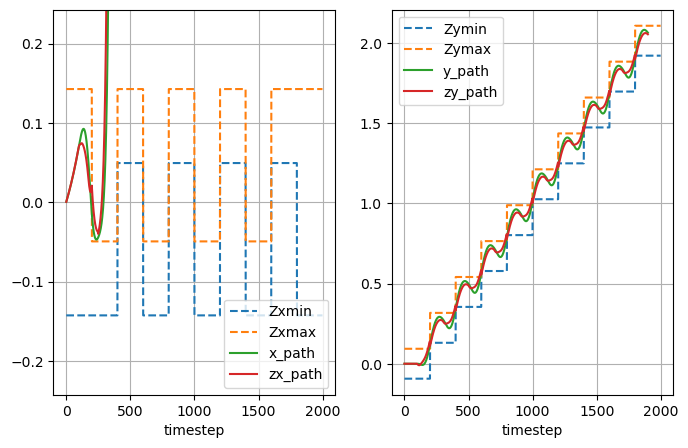

In [7]:
fig, ax = plt.subplots(1,2, figsize=(8,5))
ax[0].plot(Zxmin,'--', label= 'Zxmin')
ax[0].plot(Zxmax,'--', label="Zxmax")
ax[0].plot(x_path, label="x_path")
ax[0].plot(zx_path, label="zx_path")
ax[0].set_xlabel('timestep')
ax[0].set_ylim(min(Zxmin)-0.1, max(Zxmax)+0.1)
ax[0].grid()
ax[0].legend()

ax[1].plot(Zymin,'--', label= 'Zymin')
ax[1].plot(Zymax,'--', label="Zymax")
ax[1].plot(y_path, label="y_path")
ax[1].plot(zy_path, label="zy_path")
ax[1].set_xlabel('timestep')
ax[1].set_ylim(min(Zymin)-0.1, max(Zymax)+0.1)
ax[1].grid()
plt.legend()

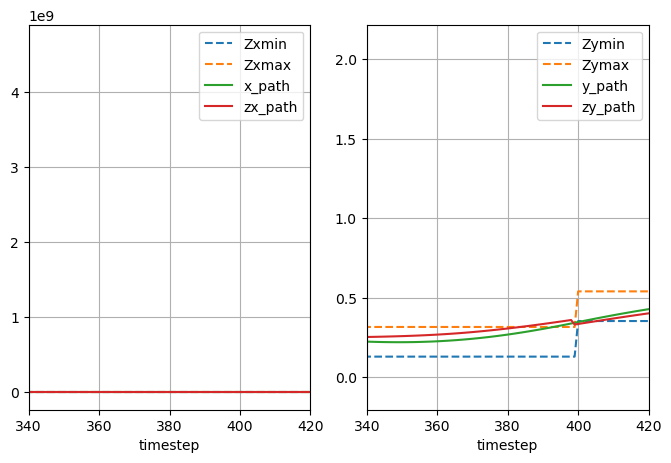

In [8]:
fig, ax = plt.subplots(1,2, figsize=(8,5))
ax[0].plot(Zxmin,'--', label= 'Zxmin')
ax[0].plot(Zxmax,'--', label="Zxmax")
ax[0].plot(x_path, label="x_path")
ax[0].plot(zx_path, label="zx_path")
ax[0].set_xlabel('timestep')
#ax[0].set_ylim(min(Zxmin)-0.1, max(Zxmax)+0.1)
ax[0].set_xlim(340,420)

ax[0].grid()
ax[0].legend()
ax[1].plot(Zymin,'--', label= 'Zymin')
ax[1].plot(Zymax,'--', label="Zymax")
ax[1].plot(y_path, label="y_path")
ax[1].plot(zy_path, label="zy_path")
ax[1].set_xlabel('timestep')
#ax[1].set_ylim(min(Zymin)-0.1, max(Zymax)+0.1)
ax[1].set_xlim(340,420)
ax[1].grid()


plt.legend()


# Move robot

In [17]:

configuration = pink.Configuration(robot.model, robot.data, robot.q0)
viz.display(configuration.q)

In [18]:
root_task = FrameTask("root_joint", position_cost=1.0, orientation_cost=1.0)
left_ankle_task = FrameTask("l_ankle", position_cost=1.0, orientation_cost=0.4)
right_ankle_task = FrameTask("r_ankle", position_cost=1.0, orientation_cost=0.4)
root_pose = configuration.get_transform_frame_to_world("root_joint").copy()
x_left_ankle = configuration.get_transform_frame_to_world("l_ankle").translation[1]
x_right_ankle = configuration.get_transform_frame_to_world("r_ankle").translation[1]
# THIS I DID IT BECAUSE I COUDN'T SET h_COM as I wanted using leg lenght
root_pose.translation[2] = leg_length +0.05
root_task.set_target(pin.SE3(rotate('z', np.pi/2), root_pose.translation))
velocity = solve_ik(configuration, [root_task], T, solver='daqp')
configuration.integrate_inplace(velocity, T)
viz.display(configuration.q)

### Create footprints

In [19]:
n_samples_per_step = step_duration // T
indices = np.arange(0, Zxmax.shape[0], n_samples_per_step+1, int)
y_values = np.array(zy_path)[indices]
feet_tracker_steps = np.array(feet_tracker)[indices]
i = 0
for j in range(len(y_values)):
    y = y_values[j]
    left_foot, right_foot = feet_tracker_steps[j]
    name_step = f'step_{i}'
    print(left_foot, right_foot)
    if left_foot:
        x = x_left_ankle
        pos = np.array([x,y,0])
        dims = [foot_width, foot_length, foot_length/10]
        color = 'red'
        viz.addBox(name_step, dims, color)
        placement = pin.SE3(np.eye(3), np.array(pos))
        viz.applyConfiguration(name_step, placement)
        i+=1
    if right_foot:
        x = x_right_ankle
        pos = np.array([x,y,0])
        dims = [foot_width, foot_length, foot_length/10]
        color = 'red'
        viz.addBox(name_step, dims, color)
        placement = pin.SE3(np.eye(3), np.array(pos))
        viz.applyConfiguration(name_step, placement)
        i+=1


1 1
0 1
1 0
0 1
1 0
0 1
1 0
0 1
1 0
1 1


In [20]:
for i in tqdm(range(len(x_path))):
    
    root_pose = configuration.get_transform_frame_to_world("root_joint").copy()
    root_pose.translation[0] = x_path[i]
    root_pose.translation[1] = y_path[i]
    # print(f'root:{root_pose.translation}')
    root_task.set_target(root_pose)
     
    left_foot, right_foot = feet_tracker[i]
    
    if (i-1) % n_samples_per_step ==0:
        print(f'New step! right:{right_foot} and left:{left_foot}')
    z_x = zx_path[i]
    z_y = zy_path[i]
    left_foot_pose = configuration.get_transform_frame_to_world("l_ankle").copy()
    right_foot_pose = configuration.get_transform_frame_to_world("r_ankle").copy()
    
    if left_foot and not right_foot:
        #left_foot_pose.translation[0] = z_x
        left_foot_pose.translation[1] = z_y
        #print('left')
    if not left_foot and right_foot:
        #right_foot_pose.translation[0] = z_x
        right_foot_pose.translation[1] = z_y
        #print('right')
    if left_foot and right_foot:
        # I am not sure if this part is correct
        #print(f'both, {z_x}, {z_y}')
        pass
        
    left_ankle_task.set_target(left_foot_pose)
    right_ankle_task.set_target(right_foot_pose)
        
    
    velocity = solve_ik(configuration, [root_task, left_ankle_task, right_ankle_task], T, solver='daqp')
    configuration.integrate_inplace(velocity, T)
    viz.display(configuration.q)
    time.sleep(T)


  0%|          | 2/786 [00:00<01:05, 11.94it/s]

New step! right:1 and left:1


 26%|██▌       | 202/786 [00:17<00:53, 11.02it/s]

New step! right:1 and left:0


 51%|█████     | 401/786 [00:36<00:34, 11.16it/s]

New step! right:1 and left:0


 59%|█████▉    | 464/786 [00:42<00:29, 10.91it/s]


KeyboardInterrupt: 